# A Polynomial Regression Analysis of PBSB Artwork Data
This analysis uses ploynomial regression to answer the following question: Can we estimate the price of a portrait?

Data wrangling performed in previous analyses is repeated here with minimal explanation. Some additional pre-processing of the input data was done in Excel. This dataset uses data at the order line level of detail which gives better visibility into individual pieces of art.

## Import libraries

In [163]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np

# Machine learning and logistic regression libraries
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


## Import Excel file

In [164]:
# Define the URL of the dataset - in this case we are using a dataset that has been uploaded to OneDrive and shared
#file_path = 'C:\\Users\\simon\\OneDrive\\Documents\\Data Analysis\\Art\\Artwork-Items.xlsx'

# Load the dataset into a DataFrame
df = pd.read_excel('Data/Artwork-Items-Reg.xlsx')

# Display the first few rows to ensure it loaded correctly
df.head()

,CustomerID,PortraitID,ServiceType,PortraitSubject,NumSubjects,Medium,SaleDate,Size,Frame,CompletedDate,ActualTime,Price,PromisedBy
0,8,10,Commission,People,1.0,Graphite,2003-04-01,11x14,NaN,2003-04-15,16,0.0,2003-04-15
1,6,12,Commission,House/dwelling,1.0,Pen & Ink / Watercolor,2003-04-01,11x14,NaN,NaT,5,0.0,NaT
2,26,62,Commission,Dog,1.0,Acrylic,2003-10-06,11x14,NaN,2003-11-09,4,0.0,2003-11-30
3,68,116,Commission,Dog,1.0,Pastel,2004-10-10,16x20,NaN,NaT,0,0.0,NaT
4,86,137,Commission,Dog,1.0,Oil,2005-06-08,24x30,NaN,NaT,0,0.0,2005-09-30


## Basic Data Cleanup
Unlike the price data used in previous analyses, the item price data is already formatted as a number and doesn't need further manipulation. There are still some rows with missing values which must be removed.

In [165]:
# Drop the rows with no order date and no sale type
df = df.dropna(subset=['SaleDate'])

In [166]:
# Filter out rows with 'Price' == 0 or 'ActualTime' == 0
df = df[(df['Price'] > 100)]
df = df[(df['ActualTime'] > 0)]

In [167]:
# Filter out any records which dont have 'ServiceType' == 'Commission' or 'ServiceType' == 'Artwork sale'
df = df[(df['ServiceType'] == 'Commission') | (df['ServiceType'] == 'Artwork sale')] 

In [168]:
df.head()

,CustomerID,PortraitID,ServiceType,PortraitSubject,NumSubjects,Medium,SaleDate,Size,Frame,CompletedDate,ActualTime,Price,PromisedBy
114,311,624,Artwork sale,NaN,0.0,NaN,2019-11-10 00:00:00,6x12,Framed,2019-03-31,8,113.53,NaT
116,208,304,Artwork sale,Landscape,0.0,Oil,2011-10-02 15:15:15,18x28,NaN,2010-08-31,20,120.00,NaT
117,215,370,Artwork sale,Landscape,0.0,Oil,2014-05-25 15:44:54,6x8,NaN,2014-03-30,2,120.00,NaT
118,21,68,Commission,Person,1.0,Color Pencil,2003-11-15 00:00:00,8x10,NaN,2003-12-07,8,125.00,2003-12-15
120,254,383,Artwork sale,Landscape,0.0,Oil,2014-06-22 09:16:00,10x8,NaN,2014-06-15,4,125.00,NaT


## Data Transformation

The source data has been cleaned up since previous analyses and obvious outliers were corrected.

### Extract 'Year'
Since the SaleDate column is already in date/time format, the Year can be extracted directly.

In [169]:
# Create a Year column
df['Year'] = df['SaleDate'].dt.year.astype(int)

### Calculate 'Area' for each item where possible
Use data in the 'Size' column to calculate the area of each painting in square incheas.

In [170]:
# Function to calculate area from 'Size' column
def calculate_area(size):
    if pd.isna(size):
        return None  
    try:
        # Convert the value to a string
        size_str = str(size)
        # Use regular expression to find the first pair of numbers (including decimals)
        match = re.search(r'(\d+(\.\d+)?)\s*[xX*]\s*(\d+(\.\d+)?)', size_str)
        if match:
            height, width = map(float, match.groups()[::2])  # Extract only the numeric parts
            return height * width
        else:
            return None  # Handle cases where the size format is incorrect
    except ValueError:
        return None  # Handle cases where the size format is incorrect

# Apply the function to the 'Size' column and create a new 'Area' column
df['Area'] = df['Size'].apply(calculate_area)

# Display the DataFrame with the new 'Area' column
print(df['Area'].head())



114     72.0
116    504.0
117     48.0
118     80.0
120     80.0
Name: Area, dtype: float64


### Remove Records With 'Area' == null

In [171]:
# Drop any records that don't have a useable 'Area'
df = df.dropna(subset=['Area'])

### Create a Price Per Hour Feature and a Price Per Area Feature

In [172]:
df['Price_Per_Hour'] = df['Price']/df['ActualTime']
df['Price_Per_Area'] = df['Price']/df['Area']

### Separate Out Commissioned Portraits
Create a dataframe that only contains commissioned paintings.

In [173]:
df_commission = df[df['ServiceType'] == 'Commission']
df_retail = df[df['ServiceType'] == 'Artwork sale']

### Drop Commission Records with Missing Dates

In [174]:
# drop any commission records with missing dates
df_commission = df_commission.dropna(subset=['CompletedDate'])

### Filter Out Mediums Other Than Oil and Pastel
The choice of medium has an impact on pricing and time taken to complete. We're just interested in oil and pastel portraits for this analysis as they make up the bulk of the studio output.

In [175]:
# Filter out values that don't start with 'Oil' or 'Pastel'
df_commission = df_commission[df_commission['Medium'].str.match(r'^(Oil|Pastel)', na=False)]

### Remove Commission Records With no Subjects

In [176]:
df_commission = df[df['NumSubjects'] > 0]

## Linear Multi Regression

### Can We Predict the Price of a Dog Portrait?
I have more data relating to dog portraits than those of other subjects, so it's natural choice to make them the target for this analysis.

I tend to price portraits based on a combination of my historical data and a rough assessment of how difficult I assess they will be to complete. In the absence of a 'difficulty' rating, we'll examine the correlation between year, area, number of subjects and price. This requires a multi-valued linear regression.

In [177]:
# Filter all portraits out of the dataframe except for those of Dogs
df_dog = df_commission[(df_commission['PortraitSubject'] == 'Dog')]

First, we'll do a check check to confirm my suspicion that Price vs. Year doesn't provide a meaningful regression line.

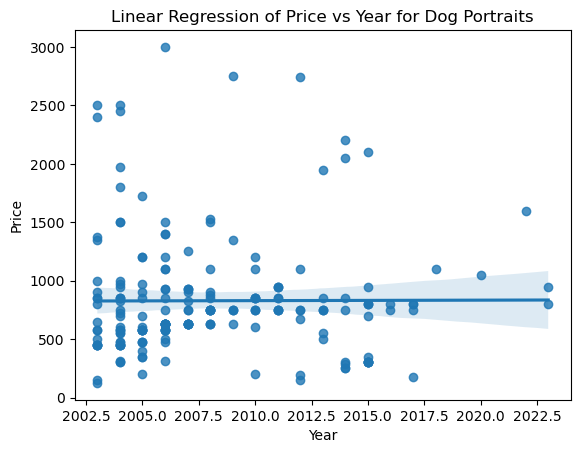

In [178]:
sns.regplot(
    x='Year',
    y='Price',
    data=df_commission
)
plt.title('Linear Regression of Price vs Year for Dog Portraits')

# Save the plot as a PNG file
plt.savefig('Graphics/price_vs_year.png', format='png', dpi=300)

plt.show()

That's a relationship that clearly not going to provide us with any meaningful insights.

However, I do have an idea what to focus on. Prices tend to be higher for larger canvas sizes (for example, I might be painting a whole body rather than just a head and shoulders portrait), and prices tend to be higher for multi-subject portraits (it takes more effort to paint two dogs than it does to paint one). In addition, prices are likely to increase over time. We can therefore plot:

1. Price per Area vs Year
2. Price per Head vs Year

One further thing:

In 2010 or so, I started doing two grades of portrait—a sketch portrait started at 400 USD per head and a formal portrait that started at around 700-800 USD. The data won't make much sense with the sketch portraits included, so I will remove them.

Before this, I didn't *officially* do sketch vs. formal portraits, but in truth I did this on an informal basis. So for portraits prior to 2010, I will also remove these lower cost portraits from the mix.  In both cases, I'll set the cutoff higher than is strictly necessary so that I also filter out some noise.

In [190]:
# Calculate price per subject. We already know that there are no zeros remaining in the NumSubjects column.
df_dog.loc[:, 'Price_Per_Head'] = df_dog['Price']/df_dog['NumSubjects']

# Calculate price per area. We already know that there are no zeros remaining in the Area column.
df_dog.loc[:, 'Price_Per_Area'] = df_dog['Price']/df_dog['Area']

# Remove rows where Price_Per_Head is less than 600 and Year is greater than 2009
df_temp = df_dog[~((df_dog['Price_Per_Head'] < 601) & (df_dog['Year'] > 2009))]

# Remove rows where Price_Per_Head is less than 400 and Year is less than 2010
df_filtered = df_temp[~((df_temp['Price_Per_Head'] < 401) & (df_temp['Year'] < 2010))]


Before we start a more complex regression, let's plot the relationships between the variables.

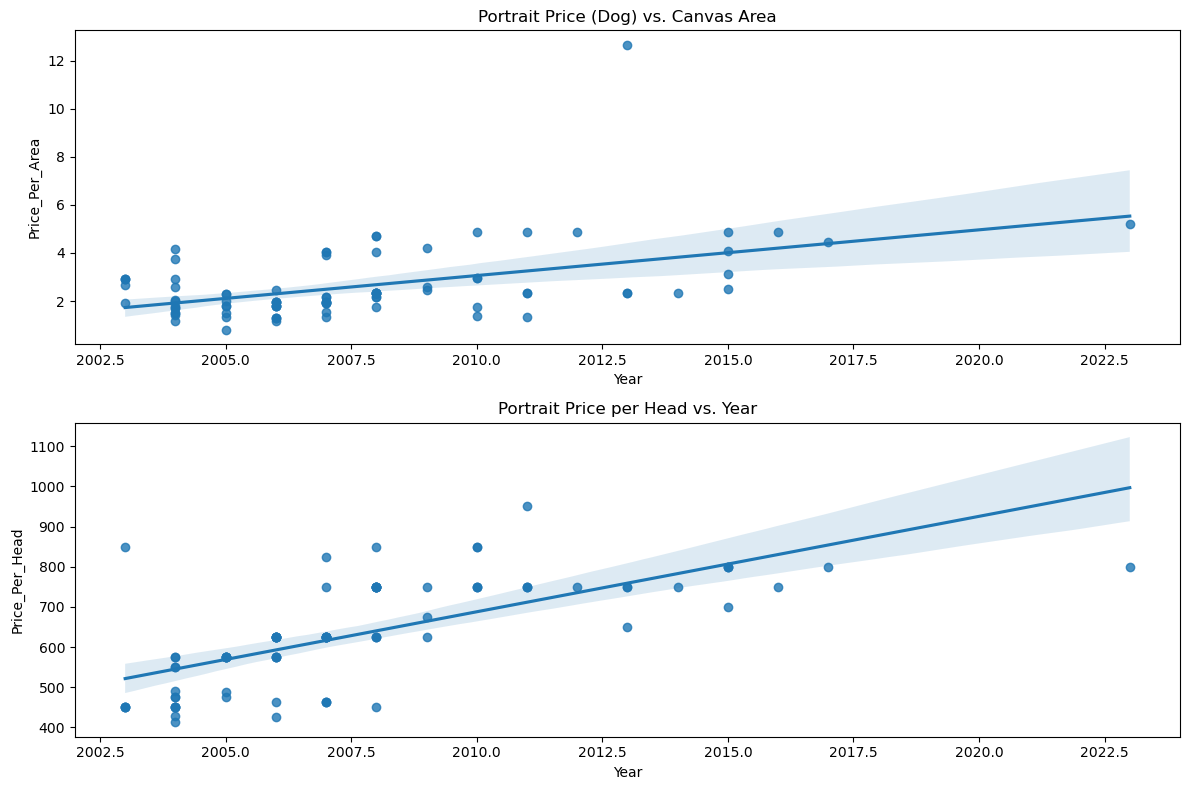

In [180]:
fig, axs = plt.subplots(2, 1, figsize=(12, 8))

sns.regplot(
    x='Year',
    y='Price_Per_Area',
    data=df_filtered,
    ax=axs[0]
)
axs[0].set_title('Portrait Price (Dog) vs. Canvas Area')

sns.regplot(
    x='Year',
    y='Price_Per_Head',
    data= df_filtered,
    ax=axs[1]
)
axs[1].set_title('Portrait Price per Head vs. Year')

plt.tight_layout()

# Save the plot as a PNG file
plt.savefig('Graphics/price_per_area_per_head_vs_year.png', format='png', dpi=300)

plt.show()

Based on these plots, we can relate price, area, number of subjects and year. Now we can try a multi-variable linear regression. 

In [181]:
#Fit linear regression to predict price using list of features
x1=df_filtered[['Year', 'Area', 'NumSubjects']]
y1=df_filtered['Price']
lre_multi=LinearRegression()
lre_multi.fit(x1, y1)
print('The R2 value is: ', lre_multi.score(x1,y1))

# Get the intercept
intercept = lre_multi.intercept_
print(f"The intercept is: {intercept}")

# Get the coefficients
coefficients = lre_multi.coef_

# Display the coefficients
for feature, coef in zip(x1.columns, coefficients):
    print(f"The coefficient for {feature} is {coef}")

The R2 value is:  0.8678301344450077
The intercept is: -52433.1759966182
The coefficient for Year is 26.194149928731722
The coefficient for Area is 0.12031041246223617
The coefficient for NumSubjects is 452.2857750676249


That produces a strong correlation. Let's estimate the cost of a two dog portrait on a 20x24 canvas in 2025 using the coefficients that were calculated above:

In [182]:
# Put data into variables
year = 2025
area = 20 * 24
num_subjects = 2

# Predict price
price = intercept + coefficients[0] * year + coefficients[1] * area + coefficients[2] * num_subjects

print('The predicted price is : $', price.round(2))

The predicted price is : $ 1572.3


Which is in the right ballpark, although a little lower than I would like it to be.

## Polynomial Regression
While straight line fitting looks good, I want to examine what might obtain by polynomial curve fitting.

To that end, we'll try training against a range of polynomial degrees and look at the root mean square error of each. To reduce the risk of overfitting, we'll then see what order of polynomial is optimal when we fit it to an out-of-sample test set.

In [183]:
X_train, X_test, y_train, y_test = train_test_split(x1, y1, test_size=0.15, random_state=10)

In [184]:
def build_polynomial_models(X_train, y_train, X_test, y_test, max_degree):
    
    train_RMSE_list = []
    test_RMSE_list = []
 
    # runs from degree = 1 to max_degree
    for degree in range(1, max_degree+1):
 
        pipeline_steps = [
            ('poly', PolynomialFeatures(degree=degree)), 
            ('scaler', StandardScaler()), 
            ('regressor', LinearRegression())
        ]
        pipeline = Pipeline(steps=pipeline_steps)
 
        # train the model using X_train and y_train
        pipeline.fit(X_train, y_train)
 
        # Predict output for X_train 
        train_predictions = pipeline.predict(X_train)    
        train_RMSE = mean_squared_error(y_train, train_predictions)**0.5
        train_RMSE_list.append(train_RMSE)
 
        # Predict output for X_test (unseen data)
        test_predictions = pipeline.predict(X_test)    
        test_RMSE = mean_squared_error(y_test, test_predictions)**0.5
        test_RMSE_list.append(test_RMSE)
    
    error_df = pd.DataFrame(
        {'Training RMSE': train_RMSE_list, 'Test RMSE': test_RMSE_list}, 
        index=range(1, max_degree+1)
    )
    error_df.index.name = 'Degree'  
    
    return error_df

In [185]:
error_df = build_polynomial_models(X_train, y_train, X_test, y_test,3)

In [186]:
error_df.round(2)

,Training RMSE,Test RMSE
Degree,,
1,111.54,122.51
2,89.91,116.20
3,67.65,137.10


The results show that the polynomial rapidly becomes overfit at third order and higher. We can visualize that by plotting the training RMSE against the test RMSE.

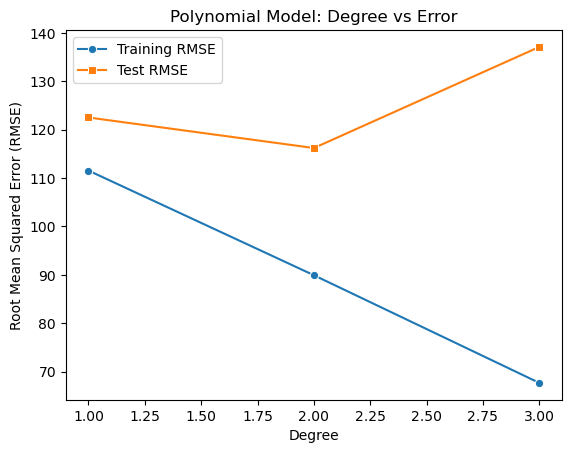

In [187]:
# Reset index to use "Degree" as a column
error_df = error_df.reset_index()

# Plot up to degree 3.
sns.lineplot(x='Degree', y='Training RMSE', data=error_df, marker='o', label='Training RMSE')
sns.lineplot(x='Degree', y='Test RMSE', data=error_df, marker='s', label='Test RMSE')

plt.title('Polynomial Model: Degree vs Error')
plt.xlabel('Degree')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.legend()

# Save the plot as a PNG file
plt.savefig('Graphics/poly_model_error.png', format='png', dpi=300)

plt.show()


The optimum polynomial appears to be second order. Clearly, the sparse portrait data after 2019 (thanks, COVID!), makes fitting in this time period and projections into the future a challenge.

## Predicting a Price Using a Second Order Polynomial
Let's fit a second order polynomial to the entire data set

In [188]:
# Degree of the polynomial
degree = 2

# Generate polynomial features
poly = PolynomialFeatures(degree=degree)
X_poly = poly.fit_transform(x1)

# Fit the model
model = LinearRegression()
model.fit(X_poly, y1)

# Get the coefficients and intercept
coefficients = model.coef_
intercept = model.intercept_

# Get feature names
feature_names = poly.get_feature_names_out(['Year', 'Area', 'NumSubjects'])

# Predict and calculate R² score
y_pred = model.predict(X_poly)
r2 = r2_score(y1, y_pred)

print("Intercept:", intercept)
print("Coefficients:")
for name, coef in zip(feature_names, coefficients):
    print(f"{name}: {coef}")

print("R² score:", r2)


Intercept: -5312758.340217695
Coefficients:
1: 0.0
Year: 5288.709863302076
Area: -60.30536117705008
NumSubjects: -39419.184523918404
Year^2: -1.3161292986936226
Year Area: 0.030290810859441963
Year NumSubjects: 19.753826213429235
Area^2: -0.0001778904048839471
Area NumSubjects: -0.10540792452618564
NumSubjects^2: 73.93718308278852
R² score: 0.9086869357574229


That produces an even stronger correlation than the multi-variable linear regression. An interesting result is that the model predicts a price decline in the future (the coefficient for Year^2 is negative) — this comes from a mild overfitting of the training data combined with the lack of data post 2019.

Still, it might get us a price estimate in the right ballpark. As before, let's estimate the cost of a two dog portrait on a 20x24 canvas in 2025 using the coefficients that were calculated above. Unfortunately, it's much more complex than the linear calculation:

In [189]:
# Put data into variables
year = 2025
area = 20 * 24
num_subjects = 2

# Predict price
price = intercept + (coefficients[1] * year) + (coefficients[2] * area) + (coefficients[3] * num_subjects) + \
        (coefficients[4] * year * year) + (coefficients[5] * year * area) + (coefficients[6] * year * num_subjects) + \
        (coefficients[7] * area * area) + (coefficients[8] * area * num_subjects) + (coefficients[9] * num_subjects * num_subjects)

print('The predicted price is : $', price.round(2))

The predicted price is : $ 1740.72


That's a very good estimate—right around where I would try to price a 20x24 two dog portrait of moderate complexity.